## Health Analytics: Logistic Regression to Guide Treatment for Diabetes Patients

Leyla Ahmadli

github repository link: https://github.com/CityDataScienceTeaching/in3061_inm430_coursework_2021-ahmadli94/tree/master/coursework

In [1]:
# Modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#### Data

The dataset was taken from UCI repository and is publicly avilable (https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)

First we will learn about the dataset and clean it in order to analis it better

# Preprocessing and cleaning of data

In [2]:
# load data
diabetic_data = pd.read_csv('diabetic_data.csv')

# explor it
diabetic_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


WE have 50 columns, let's look at their names

In [3]:
diabetic_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

['Pediatrics-Endocrinology' 'Other' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Neurology' 'Anesthesiology-Pediatric'
 'Radiology' 'Pediatrics-Hematology-Oncology' 'Psychology' 'Podiatry'
 'Gynecology' 'Oncology' 'Pediatrics-Neurology' 'Surgery-Plastic'
 'Surgery-Thoracic' 'Surgery-PlasticwithinHeadandNeck' 'Ophthalmology'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'InfectiousDiseases' 'Anesthesiology'
 'Rheumatology' 'AllergyandImmunology' 'Surgery-Maxillofacial'
 'Pediatrics-InfectiousDise

<AxesSubplot:>

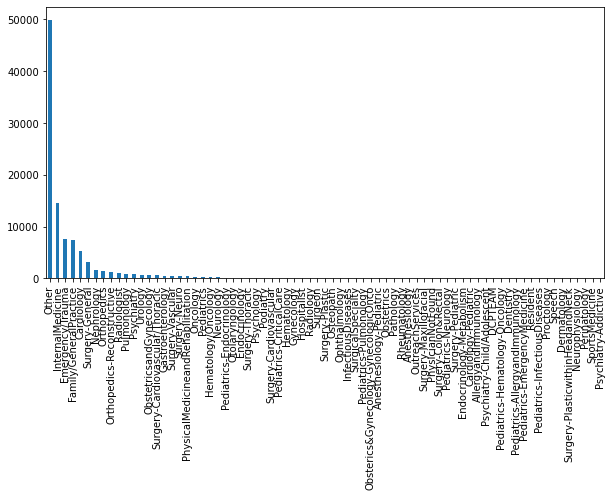

In [4]:
# Replace '?' with Other for NaN values
diabetic_data['medical_specialty'] = diabetic_data.medical_specialty.where(diabetic_data['medical_specialty'] != '?','Other')
print(diabetic_data.medical_specialty.unique())
# Let's plot medical specialty who detected diabetes in patients
fig, ax = plt.subplots(figsize = (10,5))
diabetic_data.medical_specialty.value_counts().plot(kind = 'bar')

Info indicates there is no NaN values for atributes. However, in first 5 rows question marks can be seen. We do not need columns with id, so drop all identification columns. From bargraph above it is seen that Internal Medicine specalist diagnosed diabetes in patient most, but medical_specialty column will not be benefitial in our analysis so we will also drop it.

In [5]:
# remove all the identification columns
data = diabetic_data.drop(['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id',
                           'admission_source_id','payer_code', 'medical_specialty'], axis = 1 )


In [6]:
# Replace '?' with NaN
data_with_nan = data.replace({'?': np.nan})

In [7]:
# Columns with null values
nan = data_with_nan.isna().sum()
nan[nan >0]

race       2273
weight    98569
diag_1       21
diag_2      358
diag_3     1423
dtype: int64

In [8]:
#removing weight because there are a lot of missing values, 98569 are missing out of 101766
data_new = data_with_nan.drop('weight',axis = 1)
print ('{:.2f}% of weight column is missing.'.format(nan.weight/data.shape[0]*100))

96.86% of weight column is missing.


In [9]:
data_new.diag_1.unique()

array(['250.83', '276', '648', '8', '197', '414', '428', '398', '434',
       '250.7', '157', '518', '999', '410', '682', '402', '737', '572',
       'V57', '189', '786', '427', '996', '277', '584', '462', '473',
       '411', '174', '486', '998', '511', '432', '626', '295', '196',
       '250.6', '618', '182', '845', '423', '808', '250.4', '722', '403',
       '250.11', '784', '707', '440', '151', '715', '997', '198', '564',
       '812', '38', '590', '556', '578', '250.32', '433', 'V58', '569',
       '185', '536', '255', '250.13', '599', '558', '574', '491', '560',
       '244', '250.03', '577', '730', '188', '824', '250.8', '332', '562',
       '291', '296', '510', '401', '263', '438', '70', '250.02', '493',
       '642', '625', '571', '738', '593', '250.42', '807', '456', '446',
       '575', '250.41', '820', '515', '780', '250.22', '995', '235',
       '250.82', '721', '787', '162', '724', '282', '514', 'V55', '281',
       '250.33', '530', '466', '435', '250.12', 'V53', '789', '

diag columns have undifined values like V70 and likes of it so, let's remove it

In [10]:
#removing diag_1,2,3 because of undefined information
data_new = data_new.drop(['diag_1','diag_2','diag_3'], axis = 1)

In [11]:
data_new.race.unique()

array(['Caucasian', 'AfricanAmerican', nan, 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [12]:
#replacing nan values with 'Other'
data_new['race']= data_new.replace({np.nan:'Other'})
data_new.isna().sum()

race                        0
gender                      0
age                         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
glimepirid

There is no missing values now

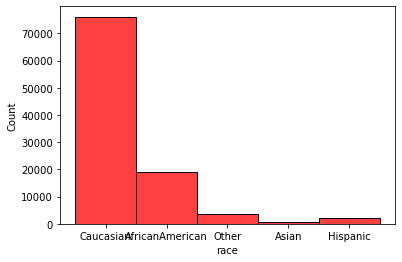

In [13]:
# Plotting number of different races
sns.histplot(data_new.race, color = 'r')
plt.show()

<AxesSubplot:>

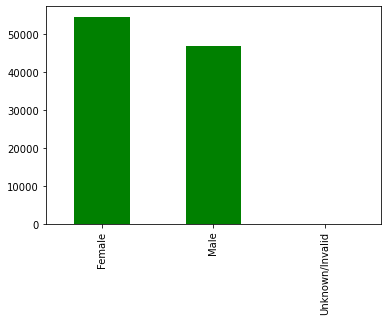

In [14]:
data_new.gender.value_counts().plot(kind = 'bar', color='g')

In [15]:
data_new.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

There are 3 unknowen values for gender lets remove them

In [16]:
# remove 3 unknoven genders
data_new = data_new.loc[data_new['gender']!='Unknown/Invalid']
data_new.gender.unique()

array(['Female', 'Male'], dtype=object)

<AxesSubplot:>

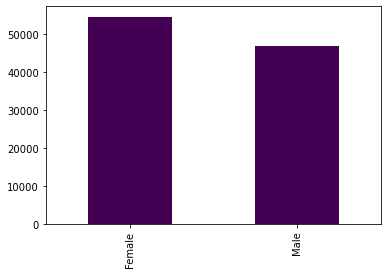

In [17]:
#Plot again
gender_count = data_new.gender.value_counts()
gender_count.plot(kind= 'bar',colormap='viridis')

In [18]:
data_new.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

Ploting histogram of all variables to have general knowledge about data

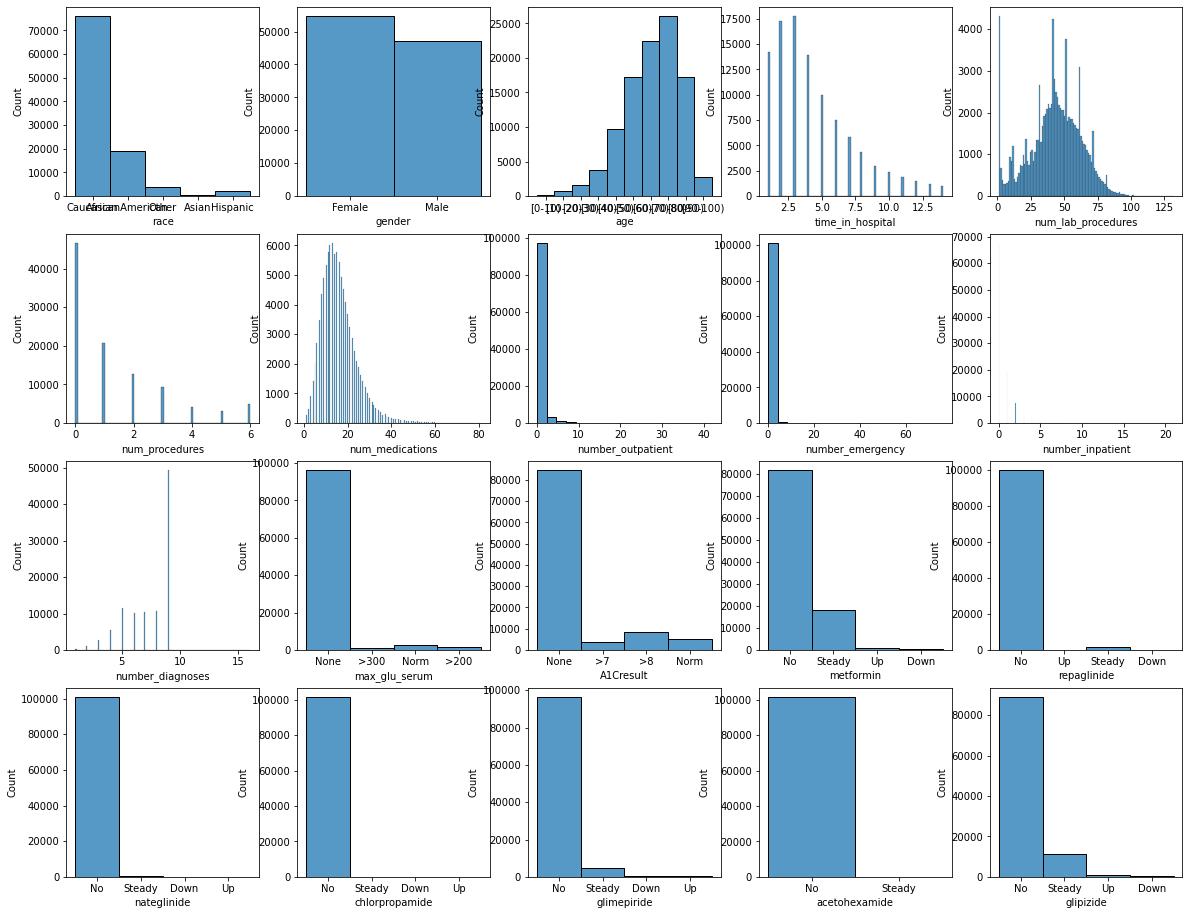

In [19]:
colnames = data_new.columns# variable names

  
fig, ax = plt.subplots(4, 5, figsize=(20,16))

for i in range(4):
    for j in range(5):  
        sns.histplot(data_new[colnames[5*i+j]], ax = ax[i,j]) # plot histogram for each column
plt.show()

From above histograms we see that there are some test that have only No or None for value, lets see what percent of tests are applicable for all patients, meaning patients been tested for.

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

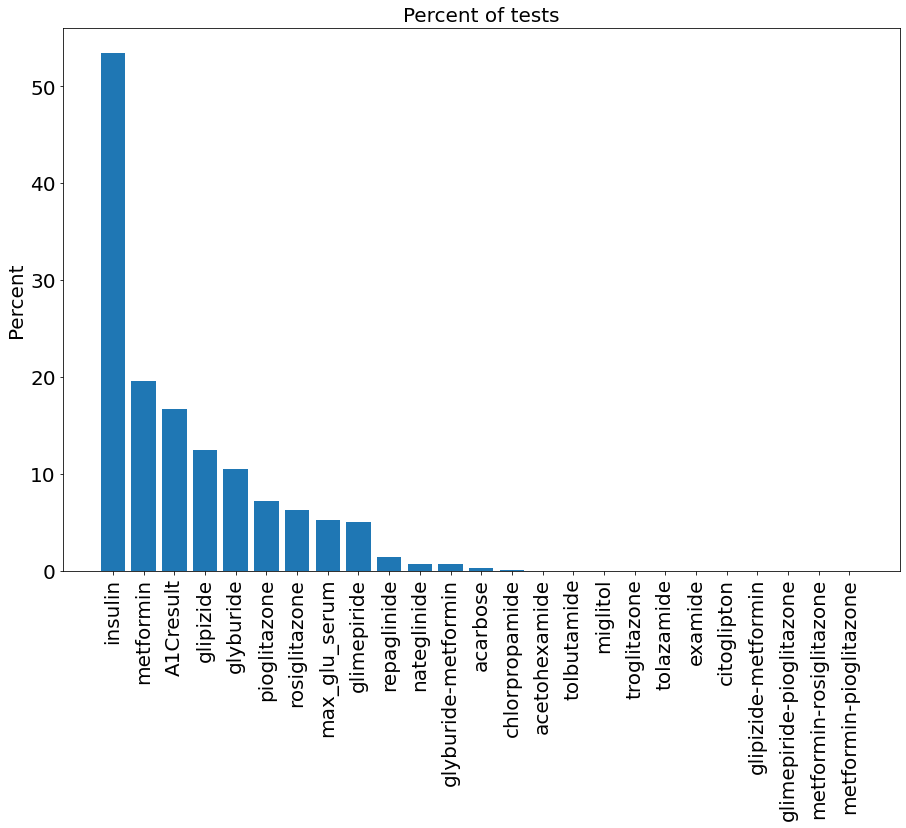

In [20]:
# Column names for tests
tests = ['max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
        'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
        'tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
        'metformin-rosiglitazone', 'metformin-pioglitazone']
percent_of_NO = {}
# calculate percents of No tests
for col in tests:
    if 'None' in data_new[col].unique():
        n = data_new[col].value_counts(normalize= True)['None']
        percent_of_NO[col]=np.round(n,3)*100
    else:
        n = data_new[col].value_counts(normalize= True)['No']
        percent_of_NO[col]=np.round(n,3)*100

percent_of_NO =dict(sorted(percent_of_NO.items(), key=lambda x:x[1]))
#plot percent of each test were taken from total patients
fig, ax = plt.subplots(figsize= (15,10) )
plt.bar(x=percent_of_NO.keys(), height= [100-value for value in percent_of_NO.values()])
plt.xticks(rotation = 90)
plt.title('Percent of tests', fontsize=20)
plt.ylabel('Percent', fontsize=20)
plt.xticks(fontsize = 20) # change x tick labels font size 
plt.yticks(fontsize = 20) # change x tick labels font size 


# reference: https://stackoverflow.com/questions/64896418/how-can-i-plot-a-seaborn-percentage-bar-graph-using-a-dictionary
#https://www.google.com/search?q=change+x+tick+labels+font+size&sourceid=chrome&ie=UTF-8

In [21]:
percent_of_NO

{'insulin': 46.6,
 'metformin': 80.4,
 'A1Cresult': 83.3,
 'glipizide': 87.5,
 'glyburide': 89.5,
 'pioglitazone': 92.80000000000001,
 'rosiglitazone': 93.7,
 'max_glu_serum': 94.69999999999999,
 'glimepiride': 94.89999999999999,
 'repaglinide': 98.5,
 'nateglinide': 99.3,
 'glyburide-metformin': 99.3,
 'acarbose': 99.7,
 'chlorpropamide': 99.9,
 'acetohexamide': 100.0,
 'tolbutamide': 100.0,
 'miglitol': 100.0,
 'troglitazone': 100.0,
 'tolazamide': 100.0,
 'examide': 100.0,
 'citoglipton': 100.0,
 'glipizide-metformin': 100.0,
 'glimepiride-pioglitazone': 100.0,
 'metformin-rosiglitazone': 100.0,
 'metformin-pioglitazone': 100.0}

From bargraph and dictionary we can see that most of the tests were not applicable to more than 99% of patients, let's remove this columns

In [22]:
# list of tests which have done by less than 5% of patients
testsToDrop=list(percent_of_NO)[9:] 
data_new =data_new.drop(testsToDrop,axis=1) # becasue they do not have any value


In [23]:
print('Number of columns left is',len(data_new.columns))

Number of columns left is 23


#### Visualising tests columns' values

In [24]:
#list of test columns we keep
TestKeepList = list(percent_of_NO)[:9]

# looking at categories of each test
for colname in TestKeepList:
    print(colname)
    print(data_new[colname].unique())

insulin
['No' 'Up' 'Steady' 'Down']
metformin
['No' 'Steady' 'Up' 'Down']
A1Cresult
['None' '>7' '>8' 'Norm']
glipizide
['No' 'Steady' 'Up' 'Down']
glyburide
['No' 'Steady' 'Up' 'Down']
pioglitazone
['No' 'Steady' 'Up' 'Down']
rosiglitazone
['No' 'Steady' 'Up' 'Down']
max_glu_serum
['None' '>300' 'Norm' '>200']
glimepiride
['No' 'Steady' 'Down' 'Up']


From above we see that 2 tests have different values, lets devide them into 2 groups

In [25]:
# Deviding tests columns into 2 groups
grp1 = []; grp2 = []
for colname in TestKeepList:
    valid_entries = data_new[colname].unique()
    if "Norm" in valid_entries:
        grp1.append(colname)
    else:
        grp2.append(colname)
    
grp1

['A1Cresult', 'max_glu_serum']

In [26]:
data_new['A1Cresult'].value_counts()

None    84745
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

In [27]:
data_new['max_glu_serum'].value_counts()

None    96417
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [28]:
# creating new data frame with 2 test columns and their value counts
c1 = data_new['A1Cresult'].value_counts()
c2 = data_new['max_glu_serum'].value_counts()
grp1_df = pd.DataFrame({'Tests':grp1, 'None':[c1['None'], c2['None']], 'High':[c1['>7'],c2['>200']], 'Higher':[c1['>8'],c2['>300']],
                         'Norm':[c1['Norm'],c2['Norm']]})

# dropping none values and calculating percentage of each result
grp1_df_copy = grp1_df.copy()
grp1_df_copy.drop(labels='None', axis=1, inplace = True)
cols = list(grp1_df_copy.columns)
grp1_df_copy['Total Num Tests'] = grp1_df_copy.sum(axis=1)
for col in cols:
    if col != 'Tests':
        grp1_df_copy['{}%'.format(col)]=grp1_df_copy[col]/grp1_df_copy['Total Num Tests']*100
grp1_df_copy

,Tests,High,Higher,Norm,Total Num Tests,High%,Higher%,Norm%
0,A1Cresult,3812,8216,4990,17018,22.399812,48.278294,29.321894
1,max_glu_serum,1485,1264,2597,5346,27.777778,23.643846,48.578376


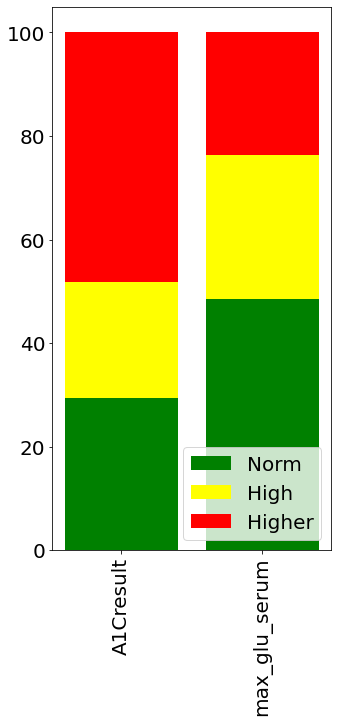

In [29]:
# plot stacked bar graph for test result 
fig, ax = plt.subplots(figsize=(5,10))
ax.bar(grp1_df_copy['Tests'],grp1_df_copy['Norm%'], label = 'Norm', color = 'green')
ax.bar(grp1_df_copy['Tests'],grp1_df_copy['High%'], label = 'High', color = 'yellow', bottom = grp1_df_copy['Norm%'])
ax.bar(grp1_df_copy['Tests'],grp1_df_copy['Higher%'], label = 'Higher', color = 'red', bottom = grp1_df_copy['Norm%'] 
       + grp1_df_copy['High%'])

plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20, rotation = 90)
ax.legend(loc = 'lower right', fontsize=20)
plt.show()

In [30]:
# creating a data frame from test columns and their value counts
entries = data_new[grp2[0]].unique()
df = pd.DataFrame({x:[0]*len(grp2) for x in entries})
df.insert(0,'Tests', grp2)
df = df.set_index('Tests')
for colname in grp2:
        count = data_new[colname].value_counts()
        for i in entries:     
            df.loc[colname,i] = count[i]
df= df.reset_index()      
df

,Tests,No,Up,Steady,Down
0,insulin,47380,11316,30849,12218
1,metformin,81776,1067,18345,575
2,glipizide,89078,770,11355,560
3,glyburide,91113,812,9274,564
4,pioglitazone,94436,234,6975,118
5,rosiglitazone,95399,178,6099,87
6,glimepiride,96572,327,4670,194


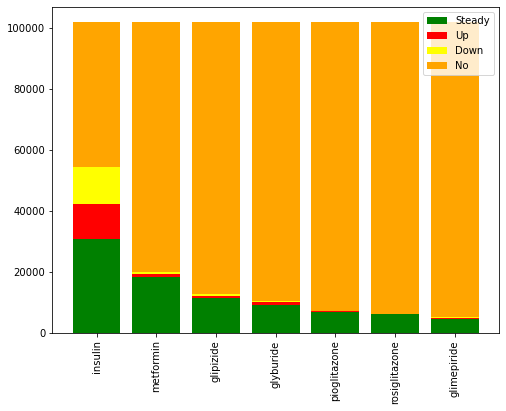

In [31]:
# plot stacked bar graph for test result or no test
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(df['Tests'],df['Steady'], label = 'Steady', color = 'green')
ax.bar(df['Tests'],df['Up'], label = 'Up', color = 'red', bottom = df['Steady'])
ax.bar(df['Tests'],df['Down'], label = 'Down', color = 'yellow', bottom = df['Steady'] + df['Up'])
ax.bar(df['Tests'],df['No'], label = 'No', color = 'orange', bottom = df['Steady'] + df['Up']+df['Down'])
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10, rotation = 90)
ax.legend(loc = 'upper right', fontsize=10)
plt.show()

In [32]:
# Adding percentage of each test result to new data frame
df_copy = df.copy()
df_copy.drop(labels='No', axis=1, inplace = True)
cols = list(df_copy.columns)
df_copy['Total Num Tests'] = df_copy.sum(axis=1)
for col in cols:
    if col != 'Tests':
        df_copy['{}%'.format(col)]=df_copy[col]/df_copy['Total Num Tests']*100
df_copy

,Tests,Up,Steady,Down,Total Num Tests,Up%,Steady%,Down%
0,insulin,11316,30849,12218,54383,20.807973,56.725447,22.466580
1,metformin,1067,18345,575,19987,5.338470,91.784660,2.876870
2,glipizide,770,11355,560,12685,6.070162,89.515175,4.414663
3,glyburide,812,9274,564,10650,7.624413,87.079812,5.295775
4,pioglitazone,234,6975,118,7327,3.193667,95.195851,1.610482
5,rosiglitazone,178,6099,87,6364,2.796983,95.835952,1.367065
6,glimepiride,327,4670,194,5191,6.299364,89.963398,3.737238


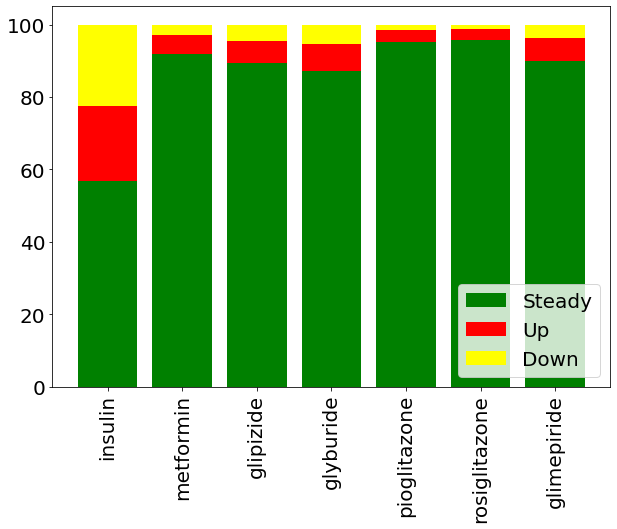

In [33]:
# plot stacked bar graph for test result
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_copy['Tests'],df_copy['Steady%'], label = 'Steady', color = 'green')
ax.bar(df_copy['Tests'],df_copy['Up%'], label = 'Up', color = 'red', bottom = df_copy['Steady%'])
ax.bar(df_copy['Tests'],df_copy['Down%'], label = 'Down', color = 'yellow', bottom = df_copy['Steady%'] + df_copy['Up%'])
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20, rotation = 90)
ax.legend(loc = 'lower right', fontsize=20)
plt.show()

### Mapping objects with integers

In [34]:
data_new.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide',
       'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

In [35]:
# assigning the columns to new data frame in which the values going to be mapped, excluding test columns and target values
df_mapped = data_new[['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                      'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']]
df_mapped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101765
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   race                101763 non-null  object
 1   gender              101763 non-null  object
 2   age                 101763 non-null  object
 3   time_in_hospital    101763 non-null  int64 
 4   num_lab_procedures  101763 non-null  int64 
 5   num_procedures      101763 non-null  int64 
 6   num_medications     101763 non-null  int64 
 7   number_outpatient   101763 non-null  int64 
 8   number_emergency    101763 non-null  int64 
 9   number_inpatient    101763 non-null  int64 
 10  number_diagnoses    101763 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 9.3+ MB


In [36]:
grp2

['insulin',
 'metformin',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'glimepiride']

In [38]:
# Mapping grp2 test columns withe integers in order of {'No','Down','Steady','Up'}, and also adding new column, because we have 
# information other than result which is test was done or not
for col in grp2:
    df_mapped['had_{}_test'.format(col)] = (data_new[col]!='No').astype('int')
    df_mapped['result_of_{}_test'.format(col)] = data_new.loc[:,col].map({'No':0,'Down':1,'Steady':2, 'Up':3})
df_mapped.head()   

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,had_glipizide_test,result_of_glipizide_test,had_glyburide_test,result_of_glyburide_test,had_pioglitazone_test,result_of_pioglitazone_test,had_rosiglitazone_test,result_of_rosiglitazone_test,had_glimepiride_test,result_of_glimepiride_test
0,Caucasian,Female,[0-10),1,41,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,...,1,2,0,0,0,0,0,0,0,0
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,...,1,2,0,0,0,0,0,0,0,0


In [39]:
grp1

['A1Cresult', 'max_glu_serum']

In [40]:
data_new['A1Cresult'].value_counts()

None    84745
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

In [41]:
# Mapping grp1 test columns in same manner as grp2
df_mapped['had_A1Cresult_test'] = (data_new['A1Cresult']!='None').astype('int')
df_mapped['result_of_A1Cresult_test'] = data['A1Cresult'].map({'None':0,'Norm':1,'>7':2,'>8':3})

In [42]:
data_new['max_glu_serum'].value_counts()

None    96417
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [43]:
# Mapping grp1 test columns in same manner as grp2
df_mapped['had_max_glu_serum_test'] = (data_new['max_glu_serum']!='None').astype('int')
df_mapped['result_of_max_glu_serum_test'] = data['max_glu_serum'].map({'None':0,'Norm':1,'>200':2,'>300':3})

In [44]:
# change indicates medicine change
data_new['change'].value_counts()

No    54754
Ch    47009
Name: change, dtype: int64

In [45]:
# maping change No,Ch  to 0, 1 , and changing name of column
df_mapped['medication_change'] = (data_new['change']=='Ch').astype(int)

In [46]:
data_new['diabetesMed'].value_counts()

Yes    78361
No     23402
Name: diabetesMed, dtype: int64

In [47]:
# maping diabetesMed Yes,No  to 1, 0, and changing name of column
df_mapped['taking_diabetesMed'] = (data_new['diabetesMed']=='Yes').astype(int)

In [48]:
data_new['readmitted'].value_counts()

NO     54861
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [49]:
# let's divide readmited into 2 groups and map as No:0, >30:1 ,<30:1
df_mapped['readmitted'] = data_new['readmitted'].map({'NO':0,'>30':1,'<30':1})
df_mapped['readmitted'].value_counts()

0    54861
1    46902
Name: readmitted, dtype: int64

In [50]:
data_new['gender'].value_counts()

Female    54708
Male      47055
Name: gender, dtype: int64

In [51]:
# let's map gender female : 1, male:0, and change the name of column
df_mapped['gender'] = data_new['gender'].map({'Female':1,'Male':0})
df_mapped.rename(columns = {'gender':'female'}, inplace=True)

In [52]:
data_new['age'].value_counts()

[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [53]:
# converting age into integers, mean of each age intervals
df_mapped['age'] = df_mapped['age'].str[1].astype('int')*10+5

In [54]:
df_mapped.head()

,race,female,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,result_of_rosiglitazone_test,had_glimepiride_test,result_of_glimepiride_test,had_A1Cresult_test,result_of_A1Cresult_test,had_max_glu_serum_test,result_of_max_glu_serum_test,medication_change,taking_diabetesMed,readmitted
0,Caucasian,1,5,1,41,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Caucasian,1,15,3,59,0,18,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,AfricanAmerican,1,25,2,11,5,13,2,0,1,...,0,0,0,0,0,0,0,0,1,0
3,Caucasian,0,35,2,44,1,16,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,Caucasian,0,45,1,51,0,8,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [55]:
# Number of duplicates
len(df_mapped[df_mapped.duplicated()])


38

In [56]:
# removing duplicates
df_mapped= df_mapped.drop_duplicates()

Now all the columns have integer values except race, we will use race as only for statistic measure, and it will be dropped for machine learning analises

### Visualization of statistics

In [57]:
# making a data frame out of age and readmitted columns value counts
age_readmitted = df_mapped.groupby(['age', 'readmitted']).count()['race'].unstack()
age_readmitted

readmitted,0,1
age,,
5,132,29
15,426,264
25,910,746
35,2163,1611
45,5379,4304
55,9668,7585
65,12081,10397
75,13515,12541
85,8886,8296


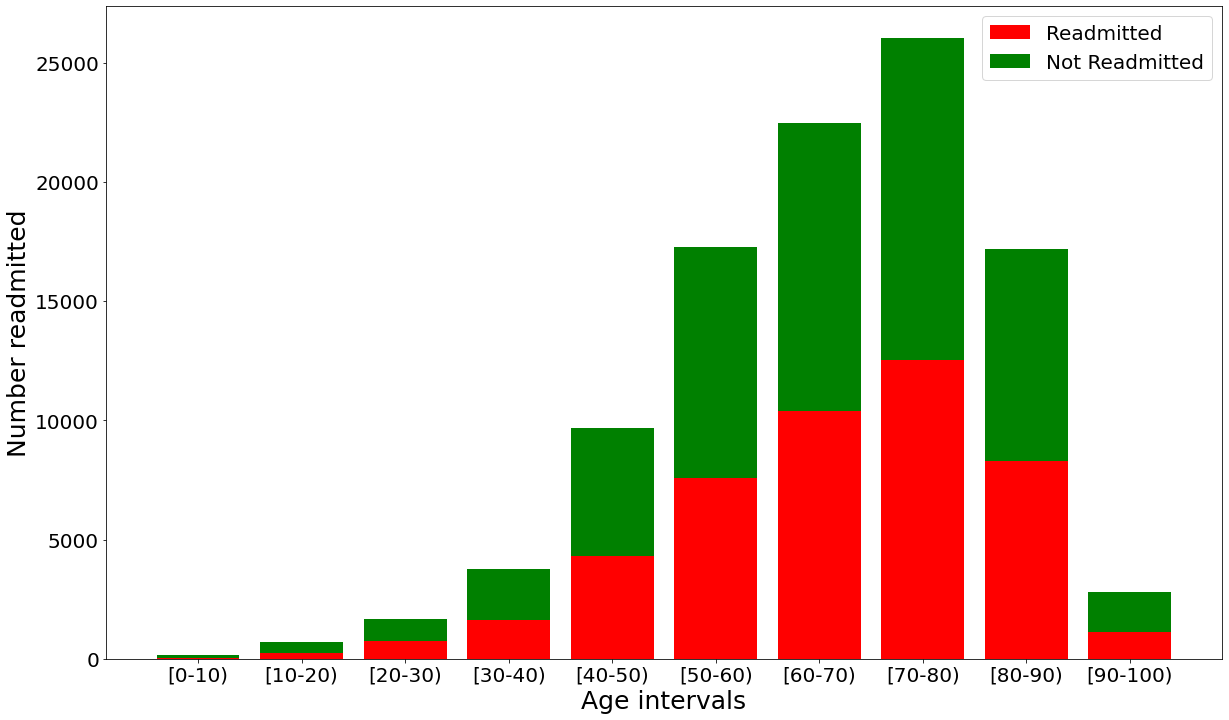

In [58]:
age_intervals = list(data_new['age'].unique())
# Plotting age vs. readmitted
fig, ax = plt.subplots(figsize=(20,12))
ax.bar(age_readmitted.index, age_readmitted[1],width=8, label = 'Readmitted' ,color = 'red')
ax.bar(age_readmitted.index, age_readmitted[0],width=8, label = 'Not Readmitted',bottom = age_readmitted[1],color = 'green')
plt.xlabel('Age intervals', fontsize=25)
plt.ylabel('Number readmitted', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(list(df_mapped['age'].unique()))
ax.set_xticklabels(age_intervals, fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [59]:
df_mapped.groupby(['medication_change','taking_diabetesMed']).count()['age'].unstack()

taking_diabetesMed,0,1
medication_change,,
0,23374.0,31343.0
1,NaN,47008.0


As seen above table, medication change is all 0 for when patients don't take diabetes medication.Target value medication_change would be considered only for patients who are taking diabetes medication

In [60]:
# data frame for medication change and age columns value counts
age_medch = df_mapped[df_mapped['taking_diabetesMed']==1].groupby(['age', 'medication_change']).count()['race'].unstack()
age_medch

medication_change,0,1
age,,
5,100,33
15,319,280
25,469,846
35,1078,1771
45,2676,4729
55,5131,8269
65,6737,10872
75,8356,11830
85,5599,7313


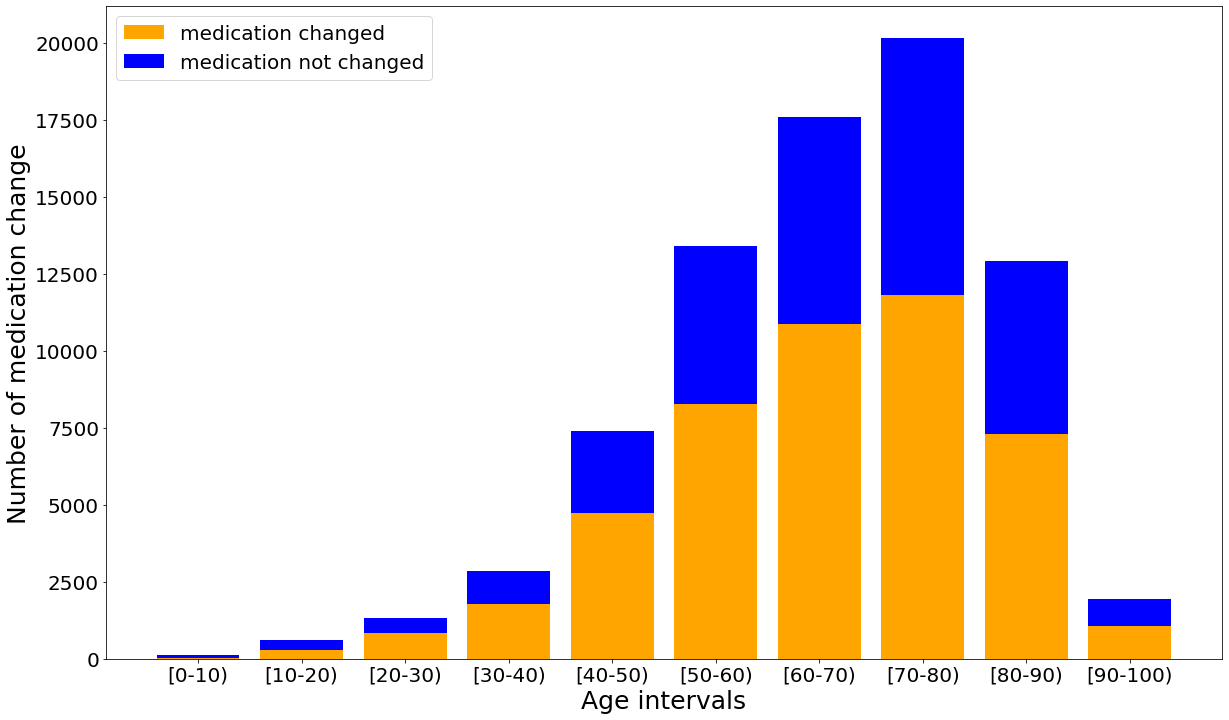

In [61]:
age_intervals = list(data_new['age'].unique())
# Plotting medication change vs. age
fig, ax = plt.subplots(figsize=(20,12))
ax.bar(age_medch.index, age_medch[1],width=8, label = 'medication changed' ,color = 'orange')
ax.bar(age_medch.index, age_medch[0],width=8, label = 'medication not changed',bottom = age_medch[1],color = 'blue')
plt.xlabel('Age intervals', fontsize=25)
plt.ylabel('Number of medication change', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(list(df_mapped['age'].unique()))
ax.set_xticklabels(age_intervals, fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [62]:
# data frame for gender and readmited with value counts
gender_readmitted = df_mapped.groupby(['female','readmitted']).count()['age'].unstack()
gender_readmitted

readmitted,0,1
female,,
0,25816,21227
1,29019,25663


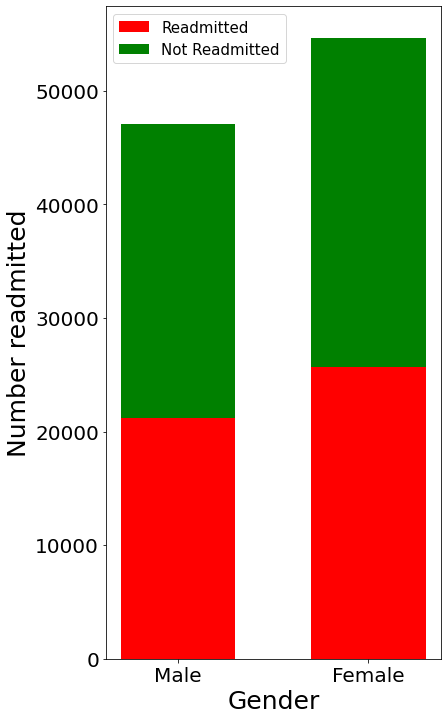

In [63]:
# Plotting gender vs readmitted
fig, ax = plt.subplots(figsize=(6,12))
ax.bar(gender_readmitted.index, gender_readmitted[1],width=0.6, label = 'Readmitted' ,color = 'red')
ax.bar(gender_readmitted.index, gender_readmitted[0],width=0.6, label = 'Not Readmitted',bottom = gender_readmitted[1],color = 'green')
plt.xlabel('Gender', fontsize=25)
plt.ylabel('Number readmitted', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks([0,1])
ax.set_xticklabels(['Male','Female'],fontsize=20)
plt.legend(fontsize=15, )
plt.show()

In [64]:
# Data frame for gender and medication_change with value counts
gender_medch = df_mapped[df_mapped['taking_diabetesMed']==1].groupby(['female','medication_change']).count()['age'].unstack()
gender_medch

medication_change,0,1
female,,
0,14458,22113
1,16885,24895


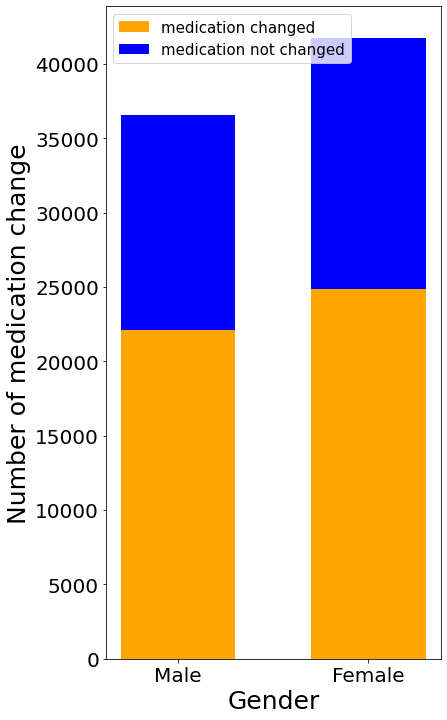

In [65]:
# Plotting gender vs medication change
fig, ax = plt.subplots(figsize=(6,12))
ax.bar(gender_medch.index, gender_medch[1],width=0.6, label = 'medication changed' ,color = 'orange')
ax.bar(gender_medch.index, gender_medch[0],width=0.6, label = 'medication not changed',bottom = gender_medch[1],color = 'blue')
plt.xlabel('Gender', fontsize=25)
plt.ylabel('Number of medication change', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks([0,1])
ax.set_xticklabels(['Male','Female'],fontsize=20)
plt.legend(fontsize=15, loc = 'upper left')
plt.show()

In [66]:
# Data frame for race and readmited with value counts
race_readmitted = df_mapped.groupby(['race', 'readmitted']).count()['age'].unstack()
race_readmitted

readmitted,0,1
race,,
AfricanAmerican,10419,8789
Asian,415,226
Caucasian,40359,35704
Hispanic,1183,854
Other,2459,1317


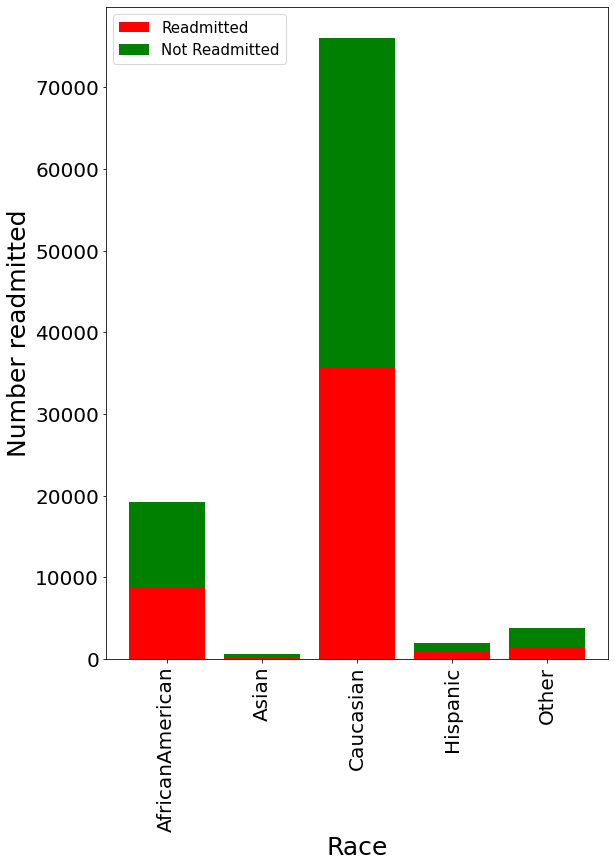

In [67]:
# Plotting race vs readmitted
fig, ax = plt.subplots(figsize=(9,12))
ax.bar(race_readmitted.index, race_readmitted[1],width=0.8, label = 'Readmitted' ,color = 'red')
ax.bar(race_readmitted.index, race_readmitted[0],width=0.8, label = 'Not Readmitted',bottom = race_readmitted[1],color = 'green')
plt.xlabel('Race', fontsize=25)
plt.ylabel('Number readmitted', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.legend(fontsize=15,loc = 'upper left'  )
plt.show()

In [68]:
# data frame for race and readmited with value counts
race_medchange = df_mapped[df_mapped['taking_diabetesMed']==1].groupby(['race', 'medication_change']).count()['age'].unstack()
race_medchange

medication_change,0,1
race,,
AfricanAmerican,6073,8723
Asian,196,279
Caucasian,23332,35110
Hispanic,562,989
Other,1180,1907


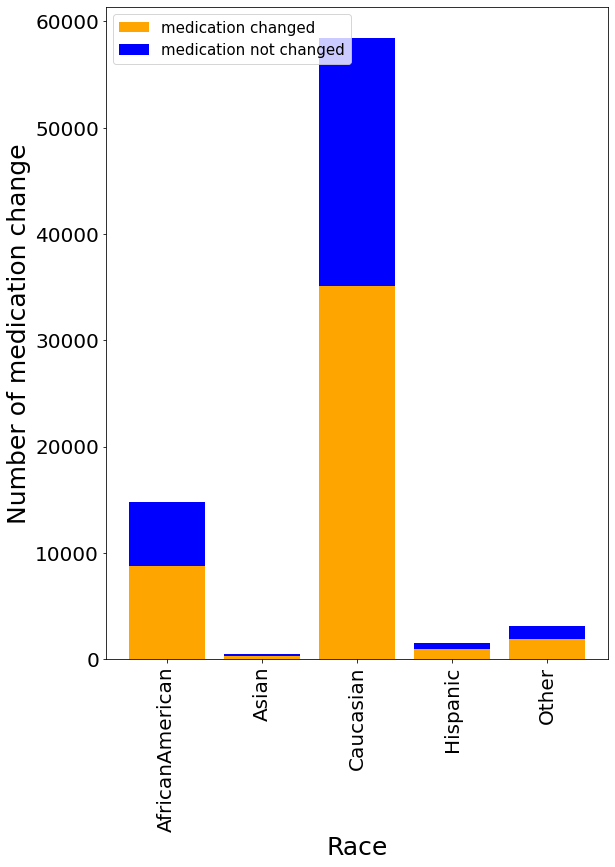

In [69]:
# Plotting race vs medication_change
fig, ax = plt.subplots(figsize=(9,12))
ax.bar(race_medchange.index, race_medchange[1],width=0.8, label = 'medication changed' ,color = 'orange')
ax.bar(race_medchange.index, race_medchange[0],width=0.8, label = 'medication not changed',bottom = race_medchange[1],color = 'blue')
plt.xlabel('Race', fontsize=25)
plt.ylabel('Number of medication change', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.legend(fontsize=15,loc = 'upper left'  )
plt.show()

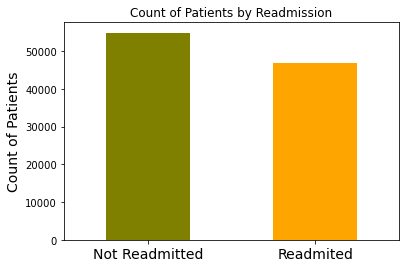

In [70]:
# Plotting readmitted bargraph
fig, ax = plt.subplots()
df_mapped['readmitted'].value_counts().plot(kind='bar',color=['olive','orange']);
ax.set_xticklabels(['Not Readmitted','Readmited'], fontsize=14, rotation =0)
plt.ylabel("Count of Patients", fontsize=14)
plt.title("Count of Patients by Readmission");

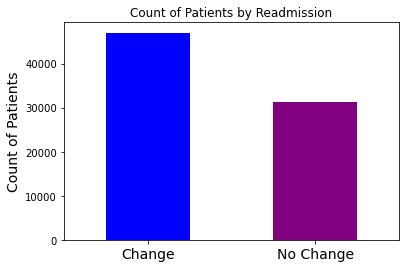

In [71]:
# Plotting medication change bargraph
fig, ax = plt.subplots()
df_mapped[df_mapped['taking_diabetesMed']==1]['medication_change'].value_counts().plot(kind='bar',color=['Blue','purple'])
ax.set_xticklabels(['Change','No Change'], fontsize=14, rotation =0)
plt.ylabel("Count of Patients", fontsize=14)
plt.title("Count of Patients by Readmission");

### Changing scale of parameters and plotting correaltion matrix

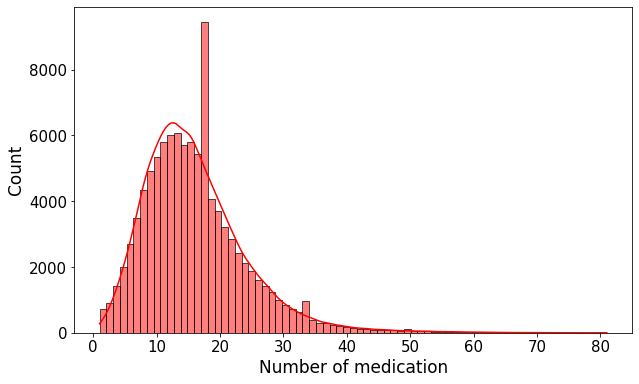

In [72]:
# When plotting all histograms it was visible that there is strong skweness in number of medication 
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.histplot(data = df_mapped, x = 'num_medications', color='r', kde = True,bins=len(df_mapped.num_medications.unique()))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_xlabel('Number of medication',fontsize=17)
ax.set_ylabel('Count',fontsize=17)
plt.show()

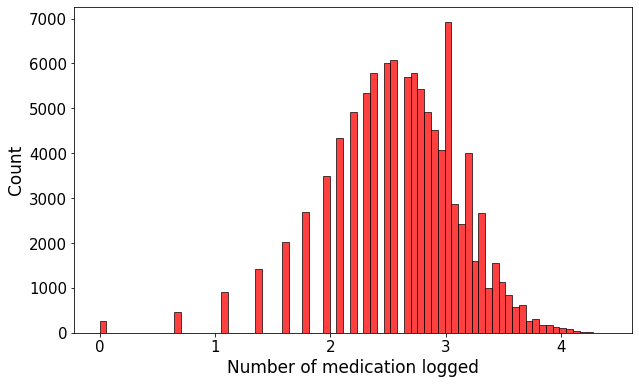

In [73]:
# In order to normalize number of medication, log of it will be taken
fig, ax = plt.subplots(figsize=(10,6))
df_mapped.insert(6, 'log_num_medications', np.log(df_mapped['num_medications']))
ax = sns.histplot( data = df_mapped, x = 'log_num_medications', color='r',bins=len(df_mapped.num_medications.unique()))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
ax.set_xlabel('Number of medication logged',fontsize=17)
ax.set_ylabel('Count',fontsize=17)
plt.show()

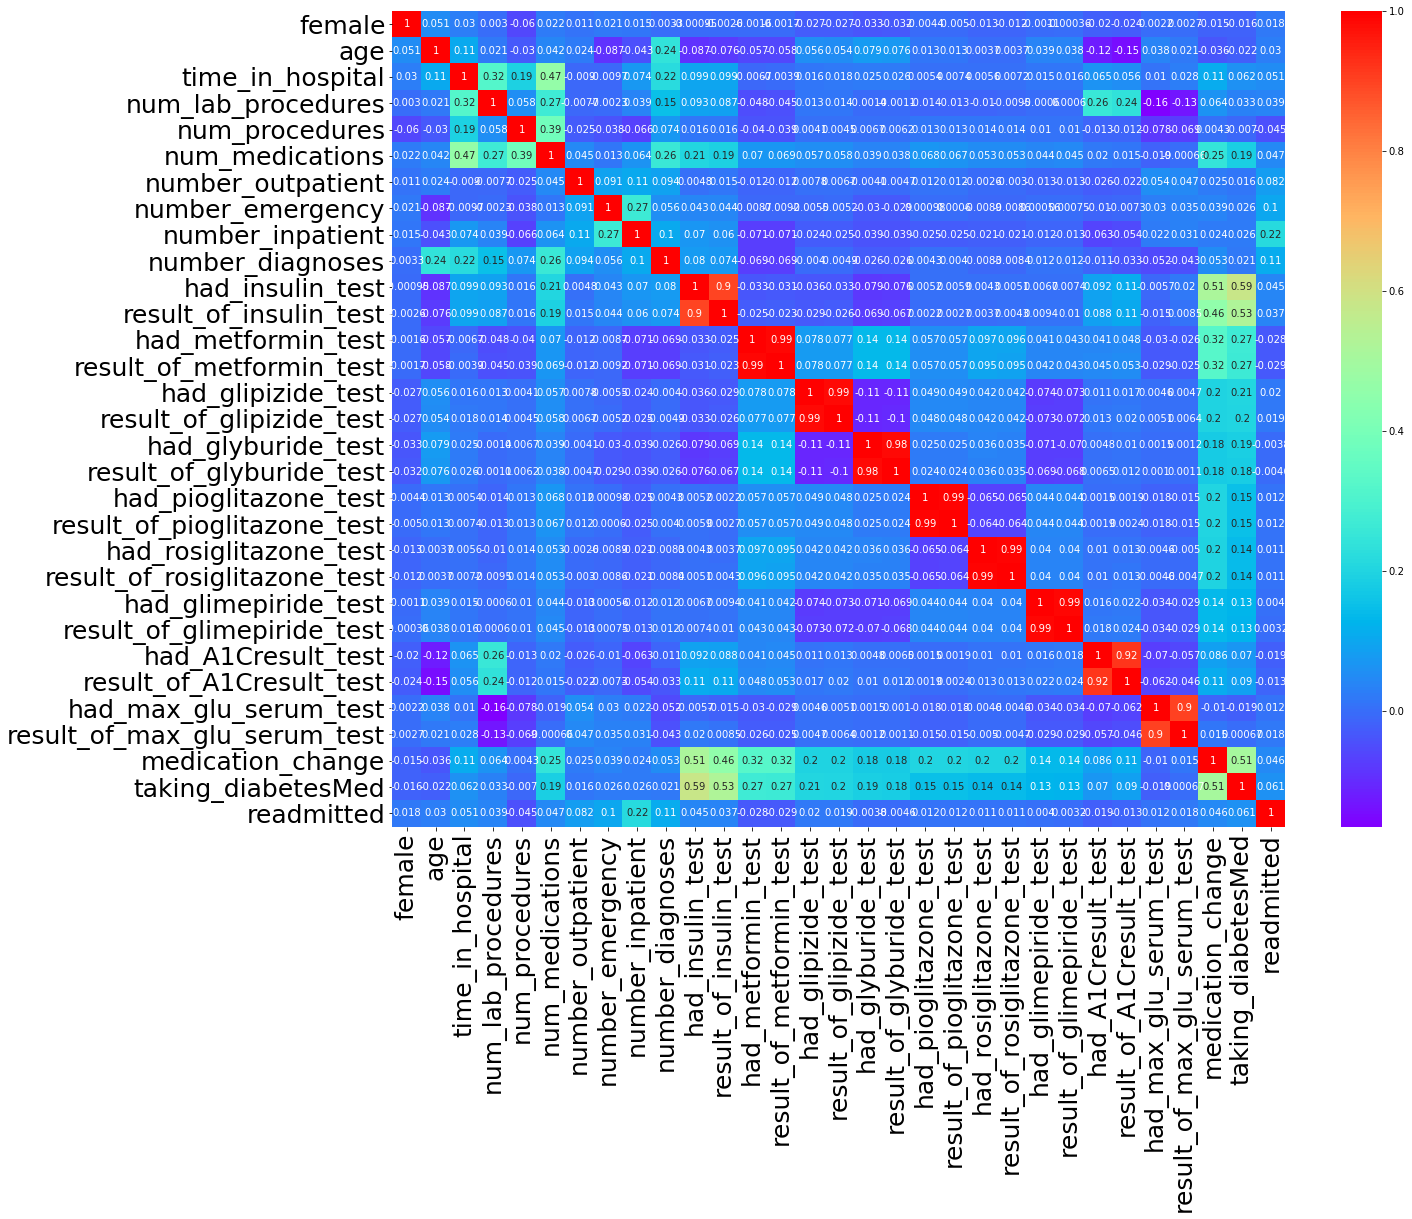

In [74]:
# Droppin race because it does not have numeric values and num_medication were normalized and were added
# to log_num_medication column so lets remove it
# data_numeric = df_mapped.drop(['race','num_medications'],axis = 1) 
# The model where num_medication is not log transformed performed better on the test set
data_numeric = df_mapped.drop(['race','log_num_medications'],axis = 1)
# Pearson correlation heatmap
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(data_numeric.corr(),annot=True, cmap = 'rainbow')

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.show()

In [75]:
clmnames= data_numeric.columns
# Normalizing values to be more compareable within themself
minmaxscaler = MinMaxScaler()
scaled_data = minmaxscaler.fit_transform(data_numeric)
scaled_data = pd.DataFrame(scaled_data, columns = clmnames)
scaled_data

,female,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,result_of_rosiglitazone_test,had_glimepiride_test,result_of_glimepiride_test,had_A1Cresult_test,result_of_A1Cresult_test,had_max_glu_serum_test,result_of_max_glu_serum_test,medication_change,taking_diabetesMed,readmitted
0,1.0,0.000000,0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.111111,0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,1.0,0.222222,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.333333,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.444444,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101720,0.0,0.777778,0.153846,0.381679,0.000000,0.1875,0.000000,0.0,0.000000,0.533333,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
101721,1.0,0.888889,0.307692,0.244275,0.500000,0.2125,0.000000,0.0,0.047619,0.533333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
101722,0.0,0.777778,0.000000,0.396947,0.000000,0.1000,0.023810,0.0,0.000000,0.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
101723,1.0,0.888889,0.692308,0.335878,0.333333,0.2500,0.000000,0.0,0.047619,0.533333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [76]:
# looking at medication change only for patients which takes diabetes medication
df_taking_diabetesMed = scaled_data[scaled_data['taking_diabetesMed']==1]
# dropping readmitted and taking_diabetesMed as first is other target value and secon has only values as 1
# dropping time_in_hospital as it is highly corelated with other predictors
X = df_taking_diabetesMed.drop(['readmitted', 'taking_diabetesMed', 'medication_change', 'time_in_hospital',
                    'result_of_insulin_test', 'had_metformin_test', 'had_glipizide_test', 'had_glyburide_test', 'had_pioglitazone_test',
                    'had_rosiglitazone_test', 'had_glimepiride_test', 'had_A1Cresult_test', 'had_max_glu_serum_test' ],axis = 1)
y = df_taking_diabetesMed['medication_change']

#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

Optimization terminated successfully.
         Current function value: 0.444128
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      medication_change   No. Observations:                52495
Model:                          Logit   Df Residuals:                    52477
Method:                           MLE   Df Model:                           17
Date:                Wed, 22 Dec 2021   Pseudo R-squ.:                  0.3407
Time:                        19:22:19   Log-Likelihood:                -23315.
converged:                       True   LL-Null:                       -35360.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
female                          -0.3541      0.023    -15.552      0.000

Text(0.5, 1.0, 'Confusion Matrix')

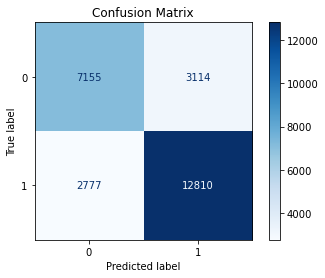

In [77]:
# Logit
lg_reg = Logit(y_train, X_train)
# fitting logistic regrestion
lg_fit = lg_reg.fit()
# printing model summary
print(lg_fit.summary())

# prediction for test set
y_pred_proba = lg_fit.predict(X_test)
y_pred = list(map(round, y_pred_proba)) # rounding to get binary values from probability
print(classification_report(y_test,y_pred)) # printing performance measures


ConfusionMatrixDisplay.from_predictions(y_test,y_pred, labels = [0,1], cmap = 'Blues')# confusion matrix
plt.title('Confusion Matrix')

#reference: https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/

Optimization terminated successfully.
         Current function value: 0.444187
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      medication_change   No. Observations:                52495
Model:                          Logit   Df Residuals:                    52481
Method:                           MLE   Df Model:                           13
Date:                Wed, 22 Dec 2021   Pseudo R-squ.:                  0.3406
Time:                        19:22:20   Log-Likelihood:                -23318.
converged:                       True   LL-Null:                       -35360.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
female                          -0.3542      0.023    -15.569      0.000

Text(0.5, 1.0, 'Confusion Matrix')

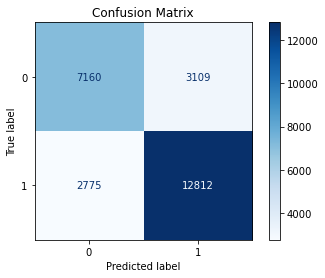

In [78]:
# dropping predictors with high p_value
X_train.drop(['number_inpatient', 'number_emergency','result_of_A1Cresult_test',
       'result_of_max_glu_serum_test' ], axis = 1, inplace = True)
X_test.drop(['number_inpatient', 'number_emergency','result_of_A1Cresult_test',
       'result_of_max_glu_serum_test' ], axis = 1, inplace = True)

# Logit
lg_reg = Logit(y_train, X_train)
# fitting logistic regrestion
lg_fit = lg_reg.fit()
# printing model summary
print(lg_fit.summary())

# prediction for test set
y_pred_proba = lg_fit.predict(X_test)
y_pred = list(map(round, y_pred_proba)) # rounding to get binary values from probability
print(classification_report(y_test,y_pred)) # printing performance measures


ConfusionMatrixDisplay.from_predictions(y_test,y_pred, labels = [0,1], cmap = 'Blues')# confusion matrix
plt.title('Confusion Matrix')

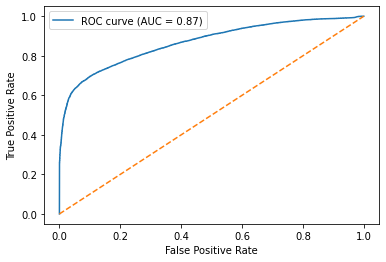

In [79]:
# plotting ROC curve
auc = roc_auc_score(y_test, y_pred_proba)

tpr, fpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(tpr, fpr, label = 'ROC curve (AUC = %0.2f)'% auc)
plt.plot([0,1],[0,1],linestyle='--', )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
#references:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [80]:
# PCA
X = df_taking_diabetesMed.drop(['readmitted', 'taking_diabetesMed', 'medication_change'], axis = 1)
y = df_taking_diabetesMed['medication_change']

# Dividing data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
# Transforming feature variables with PCA
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)
print(pca.explained_variance_ratio_)
print('Number of predictors: ', len(X.columns))
print('Number of components after PCA: ',len(pca.explained_variance_ratio_) )

[0.18981056 0.12195931 0.11920247 0.10680282 0.09722087 0.06590889
 0.06109143 0.04838241 0.04448537 0.03719051 0.03094932 0.02480437
 0.01395809 0.01059013 0.00813271 0.00650908 0.00420739]
Number of predictors:  28
Number of components after PCA:  17


Optimization terminated successfully.
         Current function value: 0.449280
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      medication_change   No. Observations:                52495
Model:                          Logit   Df Residuals:                    52478
Method:                           MLE   Df Model:                           16
Date:                Wed, 22 Dec 2021   Pseudo R-squ.:                  0.3330
Time:                        19:22:21   Log-Likelihood:                -23585.
converged:                       True   LL-Null:                       -35360.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4808      0.018    -26.583      0.000      -0.516      -0.445
x2             1.7197      0.

Text(0.5, 1.0, 'Confusion Matrix')

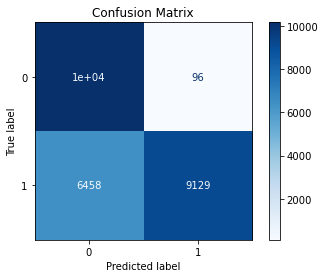

In [81]:
# Logit
lr_reg = Logit(y_train, X_train_pca)
# fitting logistic regrestion
lr_fit = lr_reg.fit()
# printing model summary
print(lr_fit.summary())

# prediction for test set
y_prb = lr_fit.predict(X_test_pca)
y_prd = list(map(round, y_prb)) # rounding to get binary values from probability
print(classification_report(y_test,y_prd)) # printing performance measures

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test,y_prd, labels = [0,1], cmap = 'Blues')# confusion matrix
plt.title('Confusion Matrix')

### Logit For Readmission

In [82]:
# Dropping highly correlated atributes
X_r = scaled_data.drop(['readmitted','taking_diabetesMed','medication_change', 'time_in_hospital', 'had_insulin_test',
                    'had_metformin_test', 'had_glipizide_test', 'had_glyburide_test', 'had_pioglitazone_test',
                    'had_rosiglitazone_test', 'had_glimepiride_test', 'had_A1Cresult_test', 'had_max_glu_serum_test'],axis = 1)
y_r = scaled_data['readmitted']

In [83]:
# Splitting into train and test sets
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r,y_r,test_size=0.33,random_state=0)

In [84]:
# Logistic regression with statmodel
mdl=Logit(y_r_train,X_r_train)
log_fit = mdl.fit()
print(log_fit.summary())

Optimization terminated successfully.
         Current function value: 0.659745
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                68155
Model:                          Logit   Df Residuals:                    68137
Method:                           MLE   Df Model:                           17
Date:                Wed, 22 Dec 2021   Pseudo R-squ.:                 0.04394
Time:                        19:22:22   Log-Likelihood:                -44965.
converged:                       True   LL-Null:                       -47031.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
female                          -0.0284      0.016     -1.803      0.071

              precision    recall  f1-score   support

         0.0       0.61      0.81      0.69     18083
         1.0       0.63      0.38      0.48     15487

    accuracy                           0.61     33570
   macro avg       0.62      0.60      0.59     33570
weighted avg       0.62      0.61      0.59     33570



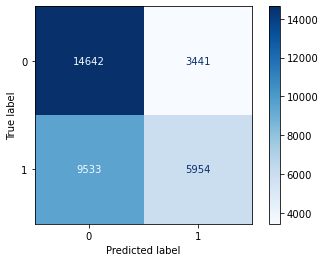

In [85]:
# predicting test set
y_pred_proba = log_fit.predict(X_r_test) 
y_pred = list(map(round, y_pred_proba)) # rounding for to get classes 0 or 1
print(classification_report(y_r_test,y_pred)) # performance measures

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_r_test,y_pred, labels = [0,1], cmap = 'Blues')

Optimization terminated successfully.
         Current function value: 0.659810
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                68155
Model:                          Logit   Df Residuals:                    68141
Method:                           MLE   Df Model:                           13
Date:                Wed, 22 Dec 2021   Pseudo R-squ.:                 0.04384
Time:                        19:22:23   Log-Likelihood:                -44969.
converged:                       True   LL-Null:                       -47031.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                             -0.6741      0.037    -18.306      0.000

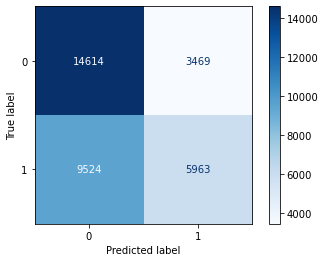

In [86]:
# dropping features with high p value
X_r_train.drop(['female', 'result_of_insulin_test','result_of_glimepiride_test',
       'result_of_max_glu_serum_test' ], axis = 1, inplace = True)
X_r_test.drop(['female', 'result_of_insulin_test','result_of_glimepiride_test',
       'result_of_max_glu_serum_test' ], axis = 1, inplace = True)

# Logistic regression with statmodel
mdl=Logit(y_r_train,X_r_train)
log_fit = mdl.fit()
print(log_fit.summary())

# predicting test set
y_pred_proba = log_fit.predict(X_r_test) 
y_pred = list(map(round, y_pred_proba)) # rounding for to get classes 0 or 1
print(classification_report(y_r_test,y_pred)) # performance measures

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_r_test,y_pred, labels = [0,1], cmap = 'Blues')

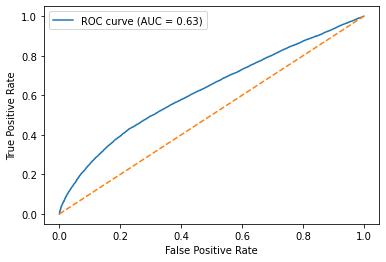

In [87]:
#ROC curve
auc = roc_auc_score(y_r_test, y_pred_proba)

tpr, fpr, _ = roc_curve(y_r_test, y_pred_proba)

plt.figure()
plt.plot(tpr, fpr, label = 'ROC curve (AUC = %0.2f)'% auc)
plt.plot([0,1],[0,1],linestyle='--', )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [88]:
X_ = scaled_data.drop(['readmitted','taking_diabetesMed','medication_change'],axis = 1)
y_ = scaled_data['readmitted']

# Splitting into train and test sets
X__train, X__test, y__train, y__test = train_test_split(X_, y_, test_size = 0.33, random_state = 0)
#PCA
pca = PCA(n_components=0.99)

X_pca_train = pca.fit_transform(X__train)
X_pca_test = pca.fit_transform(X__test)

In [89]:
# Fitting Logit model
model=Logit(y__train,X_pca_train)
log_f = model.fit()
print(log_f.summary())

Optimization terminated successfully.
         Current function value: 0.681446
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             readmitted   No. Observations:                68155
Model:                          Logit   Df Residuals:                    68138
Method:                           MLE   Df Model:                           16
Date:                Wed, 22 Dec 2021   Pseudo R-squ.:                 0.01249
Time:                        19:22:24   Log-Likelihood:                -46444.
converged:                       True   LL-Null:                       -47031.
Covariance Type:            nonrobust   LLR p-value:                3.802e-240
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1289      0.013     10.187      0.000       0.104       0.154
x2            -0.1380      0.

              precision    recall  f1-score   support

         0.0       0.61      0.51      0.55     18083
         1.0       0.52      0.61      0.56     15487

    accuracy                           0.56     33570
   macro avg       0.56      0.56      0.56     33570
weighted avg       0.57      0.56      0.56     33570



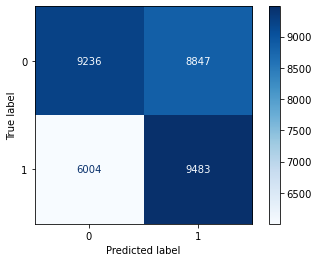

In [90]:
y_prd_prb = log_f.predict(X_pca_test)
y_prd = list(map(round, y_prd_prb))
print(classification_report(y__test,y_prd))


ConfusionMatrixDisplay.from_predictions(y__test,y_prd, labels = [0,1], cmap = 'Blues')

In [91]:
# reference: lab week 5